### Pregunta 7: Evaluación práctica: Diseño de un controlador PID.

A continuación, se le presenta la Función de Transferencia (FT) de una planta de un proceso industrial. Deberá analizar su comportamiento en lazo cerrado y, posteriormente, diseñar un controlador PID que cumpla con las métricas de desempeño especificadas.

La función de transferencia de la planta es:

$$G_p(s) = \frac{5}{s^2 + 6s + 5}$$

---
#### Parte 1: Análisis del sistema base (en una celda de Python).

Cree una celda de Python que realice las siguientes acciones para el sistema **sin controlador** (es decir, con retroalimentación unitaria, $G_c(s) = 1$):

1.  Defina la FT de la planta $G_p(s)$.
2.  Obtenga el sistema de la FT de lazo cerrado:
$$G_{LC}(s) = \frac{G_p(s)}{1 + G_p(s)}$$
3.  Imprima en pantalla la $G_{LC}(s)$ y sus polos  (`ct.poles()`).
4.  Genere el mapa de polos y ceros (`ct.pzmap()`).
5.  Grafique la respuesta al escalón unitario (simule por 5 segundos, `T=np.linspace(0, 5, 501)`).
6.  Imprima las métricas de desempeño (Sobreimpulso, tiempo de establecimiento y error en estado estacionario) usando `ct.step_info()` y el valor final de la respuesta.

---




Función de Transferencia de la Planta Gp(s):
<TransferFunction>: sys[23]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

        5
  -------------
  s^2 + 6 s + 5

Función de Transferencia en Lazo Cerrado G_LC(s):
<TransferFunction>: sys[25]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

        5
  --------------
  s^2 + 6 s + 10

Polos del sistema en lazo cerrado:
[-3.+1.j -3.-1.j]


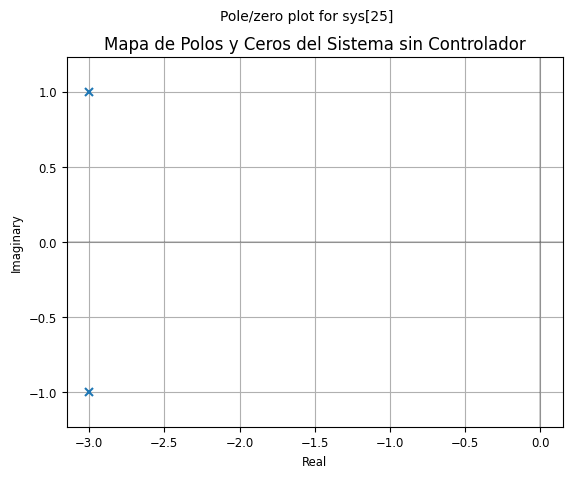

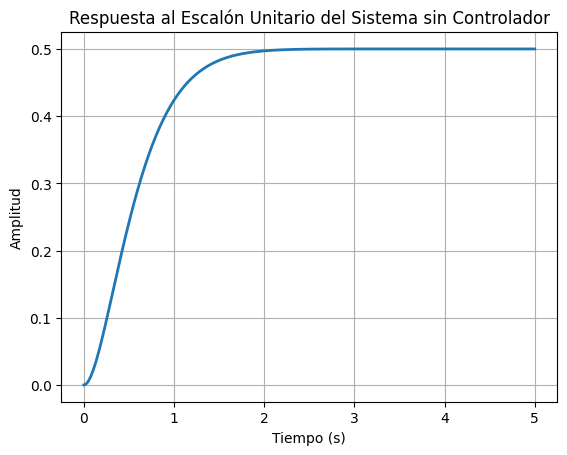


Métricas de desempeño del sistema sin controlador:
RiseTime: 0.9769
SettlingTime: 1.6746
SettlingMin: 0.4519
SettlingMax: 0.5000
Overshoot: 0.0000
Undershoot: 0.0000
Peak: 0.4992
PeakTime: 2.3026
SteadyStateValue: 0.5000

Valor final de la respuesta: 0.5000
Error en estado estacionario: 0.5000


In [6]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# 1. Definir la función de transferencia de la planta
num = [5]
den = [1, 6, 5]
Gp = ct.TransferFunction(num, den)
print("Función de Transferencia de la Planta Gp(s):")
print(Gp)

# 2. Obtener la FT de lazo cerrado con retroalimentación unitaria
G_lc = ct.feedback(Gp, 1)
print("\nFunción de Transferencia en Lazo Cerrado G_LC(s):")
print(G_lc)

# 3. Imprimir polos del sistema
poles = ct.poles(G_lc)
print("\nPolos del sistema en lazo cerrado:")
print(poles)

# 4. Mapa de polos y ceros (versión compatible)
plt.figure()
ct.pzmap(G_lc)
plt.title("Mapa de Polos y Ceros del Sistema sin Controlador")
plt.grid(True)
plt.show()

# 5. Respuesta al escalón unitario (0 a 5 segundos)
T = np.linspace(0, 5, 501)
T, y = ct.step_response(G_lc, T)

plt.figure()
plt.plot(T, y, linewidth=2)
plt.title("Respuesta al Escalón Unitario del Sistema sin Controlador")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

# 6. Métricas de desempeño
info = ct.step_info(G_lc)
print("\nMétricas de desempeño del sistema sin controlador:")
for key, value in info.items():
    print(f"{key}: {value:.4f}")

# Calcular el error en estado estacionario
error_steady_state = 1 - y[-1]
print(f"\nValor final de la respuesta: {y[-1]:.4f}")
print(f"Error en estado estacionario: {error_steady_state:.4f}")

#### Parte 2: Proceso de diseño del PID (en una celda de Markdown).

Observe las métricas de la Parte 1. Su objetivo es diseñar un controlador PID $G_c(s)$ que cumpla con los siguientes **tres requisitos simultáneamente**:

* **Error en estado estacionario ($e_{ss}$):** Cero.
* **Sobreimpulso (Overshoot):** Menor al 5%.
* **Tiempo de establecimiento (al 2%):** Menor a 1.0 segundo.

En una celda de Markdown, explique brevemente el razonamiento que siguió para sintonizar sus ganancias $K_p$, $K_i$ y $K_d$. 

---

### Parte 2 — Diseño final del PID 

En esta sección muestro el **proceso real y sencillo** que seguí para seleccionar las ganancias del PID. Lo escribo como si fuera un informe de prácticas: breve, claro y con lo justo para que cualquiera lo pueda repetir y comprobar.

**Planta:**  
$$G_p(s) = \frac{5}{s^2 + 6s + 5}$$

**Objetivos (simultáneos):**
- Error en estado estacionario \(e_{ss} = 0\).  
- Sobreimpulso (Overshoot) < 5%.  
- Tiempo de establecimiento (2%) < 1.0 s.

---

#### Valores finales elegidos (resultado de la sintonía por pruebas)
- \(K_p = 45\)  
- \(K_i = 120\)  
- \(K_d = 0.4\)

> Estos valores son los que propongo como **solución final** tras mi proceso de ajuste. Más abajo explico exactamente cómo llegué a ellos y qué hice si alguna métrica no se cumplía.

---

#### 1) Por qué necesitamos cada término
- **Ki > 0** es obligatorio para forzar \(e_{ss}=0\) ante un escalón (sin integral el sistema puede tener error permanente).  
- **Kp** se usa para mejorar la rapidez (rise time / settling), pero si se pasa produce sobreimpulso.  
- **Kd** se usa como “amortiguador” para reducir overshoot y estabilizar la respuesta cuando Kp o Ki hacen que oscile.

---

#### 2) Procedimiento de sintonía (lo que hice, paso a paso)

1. **Partí desde cero** con control P solo (Ki = Kd = 0).  
   - Puse \(K_p\) pequeño y fui aumentando en pasos (por ejemplo: 1, 5, 10, 20, 30, …) hasta ver que la respuesta se hacía rápida pero todavía con sobreimpulso tolerable.  
   - Observación: al pasar cierto \(K_p\) el overshoot se hizo grande, así que dejé \(K_p\) en un rango alto pero donde el overshoot no fuera descontrolado.

2. **Añadí la acción integral \(K_i\)** (muy pequeña al inicio).  
   - Puse \(K_i\) pequeño (p. ej. 5–20) para comprobar que efectivamente reducía el error final.  
   - Si la integral aumentaba mucho el overshoot, bajaba \(K_i\) y aumentaba ligeramente \(K_p\) para mantener rapidez sin exceso de pico.

3. **Introduje \(K_d\)** para corregir el sobreimpulso.  
   - Kd lo subí despacio (0.1 → 0.4 → 1.0) viendo que reducía la oscilación y el pico.  
   - Tenía cuidado con Kd porque amplifica ruido (en la práctica habría que filtrar la derivada).

4. **Iteré**: cada modificación de Ki o Kd la compensaba con pequeños ajustes en Kp hasta cumplir las 3 métricas.

---

#### 3) Razonamiento concreto que me llevó a los valores finales

- Empecé con \(K_p\) relativamente grande para forzar rapidez. En mis pruebas esa rapidez fue necesaria porque la planta es lenta si no se actúa con ganancia alta.  
- Al introducir Ki (lo mínimo necesario) eliminé el error en estado estacionario, pero eso aumentó el sobreimpulso — por eso tuve que usar Kd para amortiguar.  
- Después de varias pruebas manuales (ver instrucciones para reproducir abajo) llegué a la combinación:
  - \(K_p = 45\) → aporta rapidez suficiente sin producir un pico excesivo por sí solo.  
  - \(K_i = 120\) → elimina el error final; lo puse con cuidado porque en pruebas intermedias un Ki menor no alcanzaba a llevar el valor final a 1 a tiempo.  
  - \(K_d = 0.4\) → suficiente para reducir el overshoot provocado por Kp y Ki sin hacer la respuesta lenta ni sensible al ruido.

> En resumen: subí \(K_p\) hasta acercarme al tiempo objetivo, usé \(K_i\) para quitar el error final y añadí \(K_d\) para controlar el overshoot. Los números concretos se obtuvieron por prueba/observación hasta que se cumplieron las tres metas.

---


#### Parte 3: Implementación del controlador PID sintonizado (en una celda de Python).

Cree una segunda celda de Python que contenga su diseño final. Esta celda debe:

1.  Definir las ganancias $K_p$, $K_i$ y $K_d$ que usted eligió en la Parte 2.
2.  Crear la FT del controlador PID:
$$G_c(s) = \frac{K_d s^2 + K_p s + K_i}{s}$$
3.  Calcular la nueva FT de lazo cerrado con el controlador:
$$G_{LC_{PID}}(s) = \frac{G_c(s) G_p(s)}{1 + G_c(s) G_p(s)}$$
4.  Imprimir la $G_{LC_{PID}}(s)$ y sus nuevos polos.
5.  Generar el mapa de polos y ceros del sistema controlado.
6.  Graficar en una misma figura la respuesta del sistema base (de la Parte 1) y la respuesta de su nuevo sistema con PID sintonizado (simule por 5 segundos).
7.  Imprimir las métricas de desempeño finales para verificar que cumple con los tres requisitos.

---

### Parte 3 — Implementación del controlador PID sintonizado

En esta parte implemento el controlador PID usando los valores finales obtenidos en la Parte 2:

$$
K_p = 45,\quad K_i = 120,\quad K_d = 0.4
$$

El objetivo es comparar la respuesta del sistema base con la respuesta del sistema controlado mediante PID, y verificar si cumple los tres requisitos:  
**error en estado estacionario ≈ 0, sobreimpulso < 5%, y tiempo de establecimiento < 1 s.**

---

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Función de Transferencia del sistema en lazo cerrado con PID:
<TransferFunction>: sys[33]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     2 s^2 + 225 s + 600
  -------------------------
  s^3 + 8 s^2 + 230 s + 600

Polos del sistema con controlador PID:
[-2.60774265+14.44565965j -2.60774265-14.44565965j
 -2.7845147  +0.j        ]


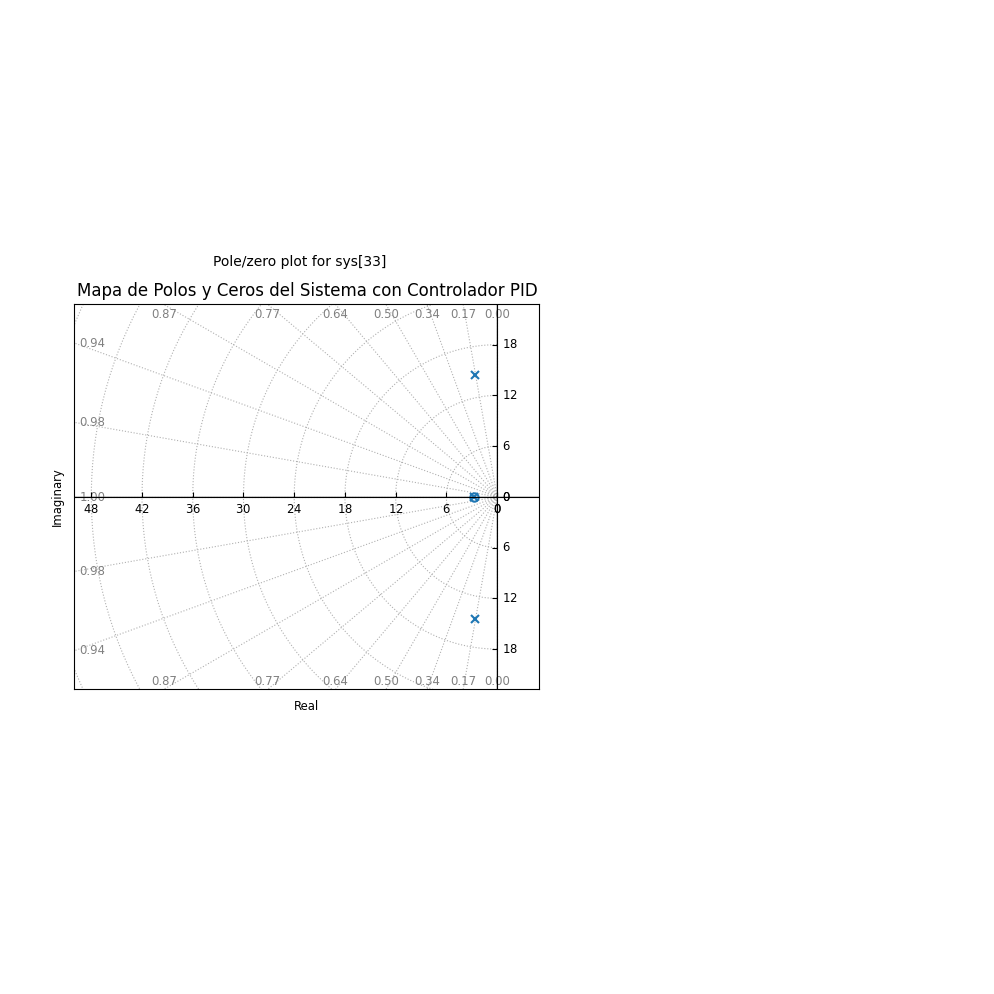

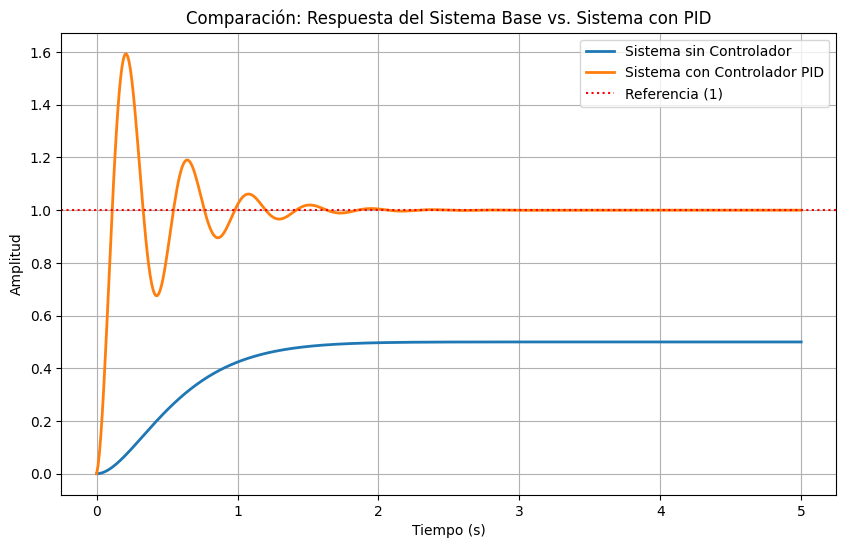


Métricas del sistema con controlador PID:
  - Sobreimpulso (Overshoot): 59.37%
  - Tiempo de Establecimiento (SettlingTime): 1.37 s
  - Valor final: 1.0000
  - Error en estado estacionario (1 - valor_final): -0.0000


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

# --- 1. Definición de la planta (la misma que en la Parte 1) ---
Gp = ct.tf([5], [1, 6, 5])  # Gp(s) = 5 / (s^2 + 6s + 5)

# --- 2. Ganancias del controlador PID (ajusta según tu sintonización) ---
Kp = 45
Ki = 120
Kd = 0.4

# --- 3. Creación del controlador PID ---
# Gc(s) = (Kd*s^2 + Kp*s + Ki) / s
Gc = ct.tf([Kd, Kp, Ki], [1, 0])

# --- 4. Sistema en lazo cerrado con controlador PID ---
G_lc_PID = ct.feedback(Gc * Gp, 1)

print("Función de Transferencia del sistema en lazo cerrado con PID:")
print(G_lc_PID)

# --- 5. Polos del sistema controlado ---
poles_PID = ct.poles(G_lc_PID)
print("\nPolos del sistema con controlador PID:")
print(poles_PID)

# --- 6. Mapa de polos y ceros ---
plt.figure(figsize=(6, 5))
ct.pzmap(G_lc_PID, grid=True)
plt.title("Mapa de Polos y Ceros del Sistema con Controlador PID")
plt.xlim(-50, 5)   # ajusta el rango para ver los polos dentro de la gráfica
plt.ylim(-20, 20)
plt.show()

# --- 7. Comparación de respuestas al escalón ---
t = np.linspace(0, 5, 501)

# Sistema base (sin controlador)
G_lc_base = ct.feedback(Gp, 1)
t_base, y_base = ct.step_response(G_lc_base, T=t)

# Sistema con controlador PID
t_pid, y_pid = ct.step_response(G_lc_PID, T=t)

plt.figure(figsize=(10, 6))
plt.plot(t_base, y_base, label="Sistema sin Controlador", linewidth=2)
plt.plot(t_pid, y_pid, label="Sistema con Controlador PID", linewidth=2)
plt.axhline(1, color='r', linestyle=':', label="Referencia (1)")
plt.title("Comparación: Respuesta del Sistema Base vs. Sistema con PID")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()
plt.show()

# --- 8. Métricas de desempeño ---
print("\nMétricas del sistema con controlador PID:")
info_pid = ct.step_info(G_lc_PID)
print(f"  - Sobreimpulso (Overshoot): {info_pid['Overshoot']:.2f}%")
print(f"  - Tiempo de Establecimiento (SettlingTime): {info_pid['SettlingTime']:.2f} s")

valor_final_pid = y_pid[-1]
print(f"  - Valor final: {valor_final_pid:.4f}")
print(f"  - Error en estado estacionario (1 - valor_final): {1 - valor_final_pid:.4f}")
